# DTEK0042 Exercise 3
    Group Members:
    1. Risto Luukkonen
    2. Usairim Isani
    3. Jonathan Costa

*** Note for Google Colab Users ***
     Because Google Colab doesn't have a button to convert your notebook to .html format here is a quick work around:
   1. open a new google colab notebook
   2. in the files section in google colab, upload the .ipynb file you want to be converted to .html
   3. in your new open notebook run this command in an empty cell: !jupyter nbconvert --to html YourFileName.ipynb
   4. after the command is finished running refresh the page
   5. In your files section you should see your original .ipynb file that you uploaded and then a .html file of that same notebook.
   6. download the .html file and you're good to go!

In this exercise, you are required to analyze a PPG signal step-by-step as outlined below.  The deliverables for this exercise are a jupyter notebook and a .html file exported form the notebook. The notebook should includes your code, observations, graphs, and conclusions made upon analyzing the given PPG signal. Please provide caption and description for every figure. 

## 1- library Imports

In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

# 2- Data Import and plotting
* Import the PPG signal data “PPG_record.txt” into your python environment and store it in a variable named “PPG_data”.
* The first column contains timestamp of samples, the second one contains red, the third one contains infrared (IR), and the last column contains green sensor data. 
* Take IR signal and store it in a variable called “PPG_sig”.  
* Note: the sampling frequency of this signal is 132 Hz. 
* Plot the IR signal stored in "PPG_sig" VS Time in seconds
* When plotting the data "PPG_sig" vs time in seconds, use the function np.linspace to make a seconds array using the length of "PPG_sig" and the sampling frequency of 132 Hz. Do not use the timestamp column of the data.

     HINT: 
         PPG_data = np.loadtxt(the directory of the PPG Data) 
         
         or
         
         PPG_data = pd.read_csv(the directory of the PPG Data, names = [name for each column])
         * Note: If you are using pandas to load into data, we'd recommend you convert pandas series data to numpy type for further analysis

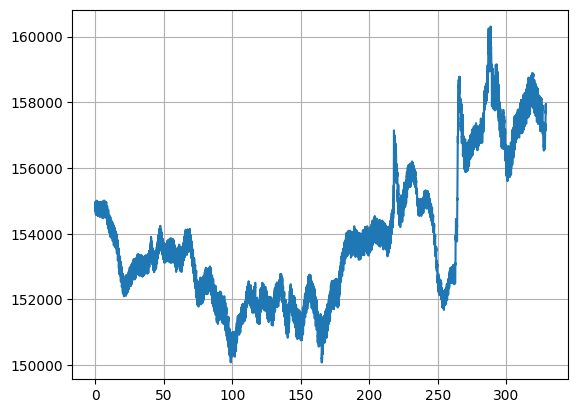

In [3]:
#code
Fs=132

PPG_data = np.loadtxt('PPG_record.txt', delimiter=',')
PPG_sig = PPG_data[:,2]
time = np.linspace(0, len(PPG_data)/Fs, len(PPG_sig))
plt.plot(time, PPG_sig)
plt.grid()
plt.show()

# 3- Compute power spectral density (PSD)

 * Compute power spectral density (PSD) using the Welch method provided by scipy package.  Select only the frequencies between 0.7 and 3Hz since the human heart rate typically does not go beyond these limits. 
 * Plot the limited PSD versus frequency
 * Find the dominant PSD value and its corresponding frequency. 
 * Store the value of the found frequency component in a variable named “dominant_freq”. 
 * Reference:
 https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch
 
      
      HINT: 
        PSD_freqs , PSD = scipy.signal.welch() 
        Set the nperseg parameter to be = 10*Fs
        

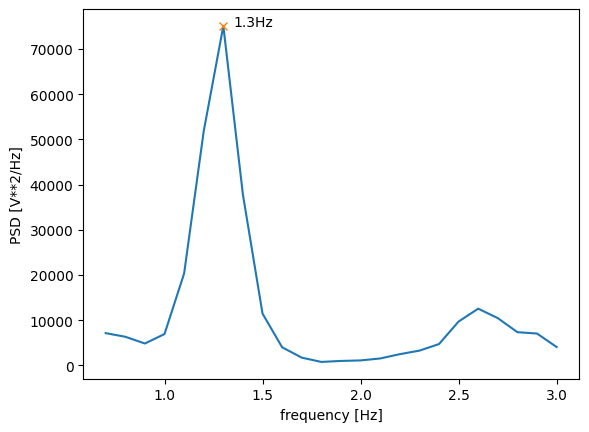

In [12]:
# code
from scipy import signal
PSD_freqs, PSD = signal.welch(PPG_sig, fs=Fs, nperseg=10*Fs)
mask = (PSD_freqs>=0.7 ) & (PSD_freqs<=3)
PSD_freqs = PSD_freqs[mask]
PSD = PSD[mask]
plt.plot(PSD_freqs, PSD)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
dominant_idx = np.argmax(PSD) 
dominant_freq = PSD_freqs[dominant_idx]
plt.text(PSD_freqs[dominant_idx]+0.05, PSD[dominant_idx], f'{PSD_freqs[dominant_idx]}Hz')
plt.plot(PSD_freqs[dominant_idx], PSD[dominant_idx], 'x')
plt.show()

# 4- Band Pass Filter Design and Filtering of PPG signal
*  Design a band pass filter. Use Butterworth filter of order 4 with cutoff frequencies equal to (dominant_freq – 0.3) and (dominant_freq + 0.3).

* Filter the original PPG signal with the designed filter. 

* Plot the filtered PPG signal showing heartbeats in the form of a sinusoid


* Note: the documentation of scipy package online is very comprehensive and informative. there are examples that 
  you can easily follow and use to solve the given exercise here. 
  https://docs.scipy.org/doc/scipy-0.14.0/reference/signal.html    
    
   
      HINT: 
        from scipy.signal import butter, filtfilt, freqz
    

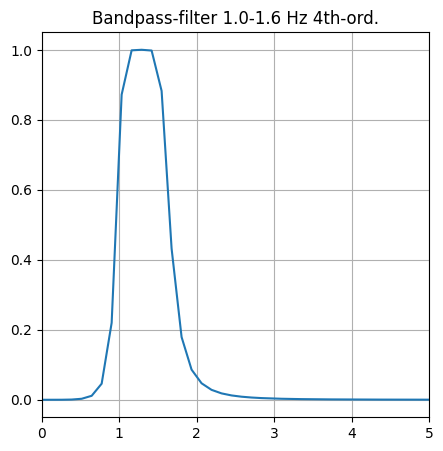

In [5]:
# code
from scipy.signal import butter, filtfilt, freqz
bandpass4 = butter(4, Wn=[dominant_freq-0.3, dominant_freq+0.3], btype='bandpass', fs=Fs)

w4, h4 =freqz(*bandpass4, fs=Fs)

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(w4, np.abs(h4))
ax.grid()
plt.xlim(0,5)
ax.set_title(f"Bandpass-filter {dominant_freq-0.3}-{dominant_freq+0.3} Hz 4th-ord.")
plt.show()

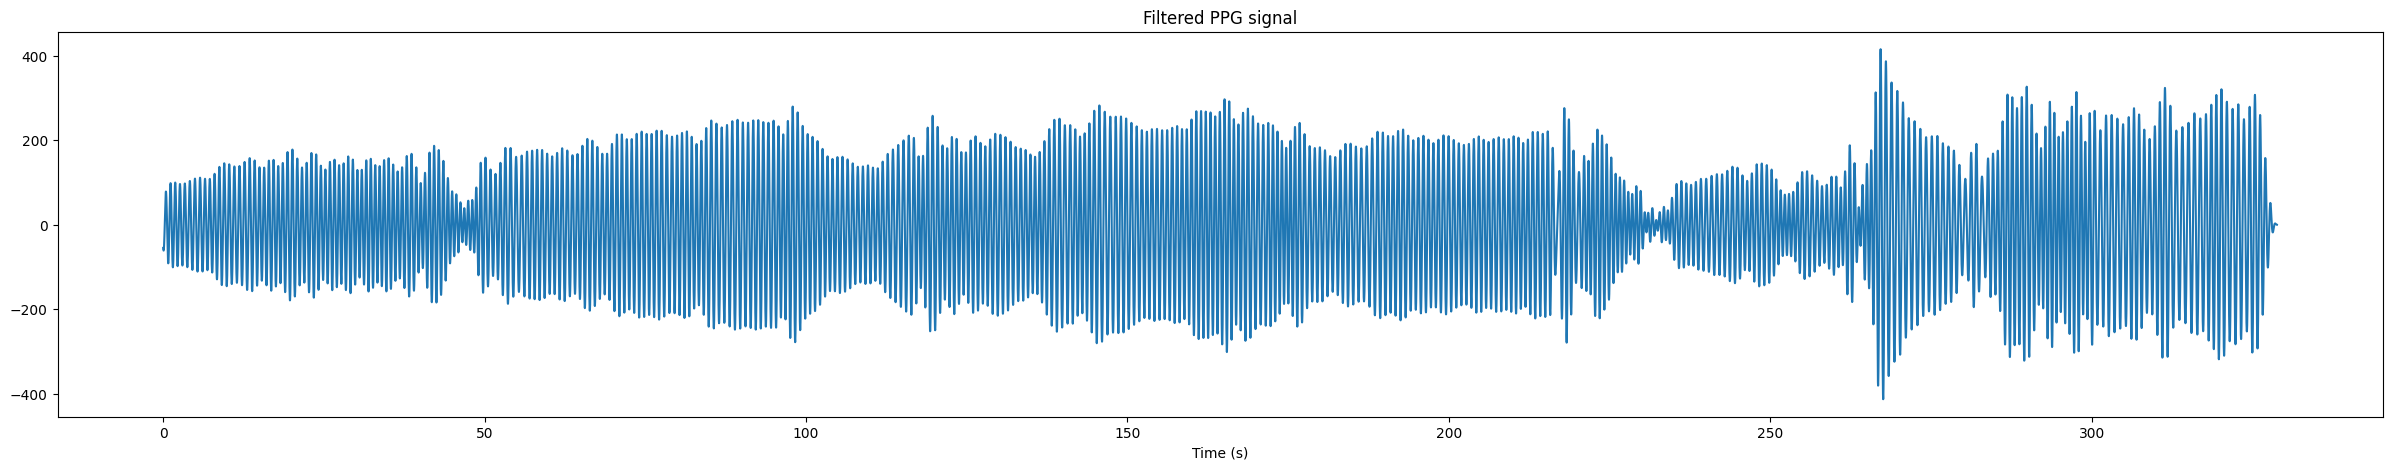

In [103]:
filt_signal = signal.filtfilt(*bandpass4, PPG_sig)
fig, ax = plt.subplots(1,1, figsize=(30,5))
# ax.plot(time, PPG_sig)
ax.plot(time, filt_signal)
ax.set_title("Filtered PPG signal")
ax.set_xlabel("Time (s)")
plt.show()

## Observations:
After filtering, the signal is nicely centered around 0. The noise outside the dominant frequency 1.3Hz is gone and the signal is clear. 

# 5- Find the maximum extrema points (or peaks) of the signal
* The distance between every two consecutive peak location correlates with the RR interval.
* Find the peaks of the filtered signal in the time domain.
* Calculate these peak-to-peak intervals, store it in a variable named “RR_intervals” and report the average value of these intervals. 
* Convert the computed average value to heart rate as shown below and report it
* You can use “argrelextrema” function in scipy package for peak detection
* Plot Filtered PPG With peak locations
* Describe your observations below
* Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelextrema.html

      HINT:
        from scipy.signal import argrelextrema
        HeartRate = 60.0/avg_peak_intervals 

Average heart rate: 78.446623713541 BPM


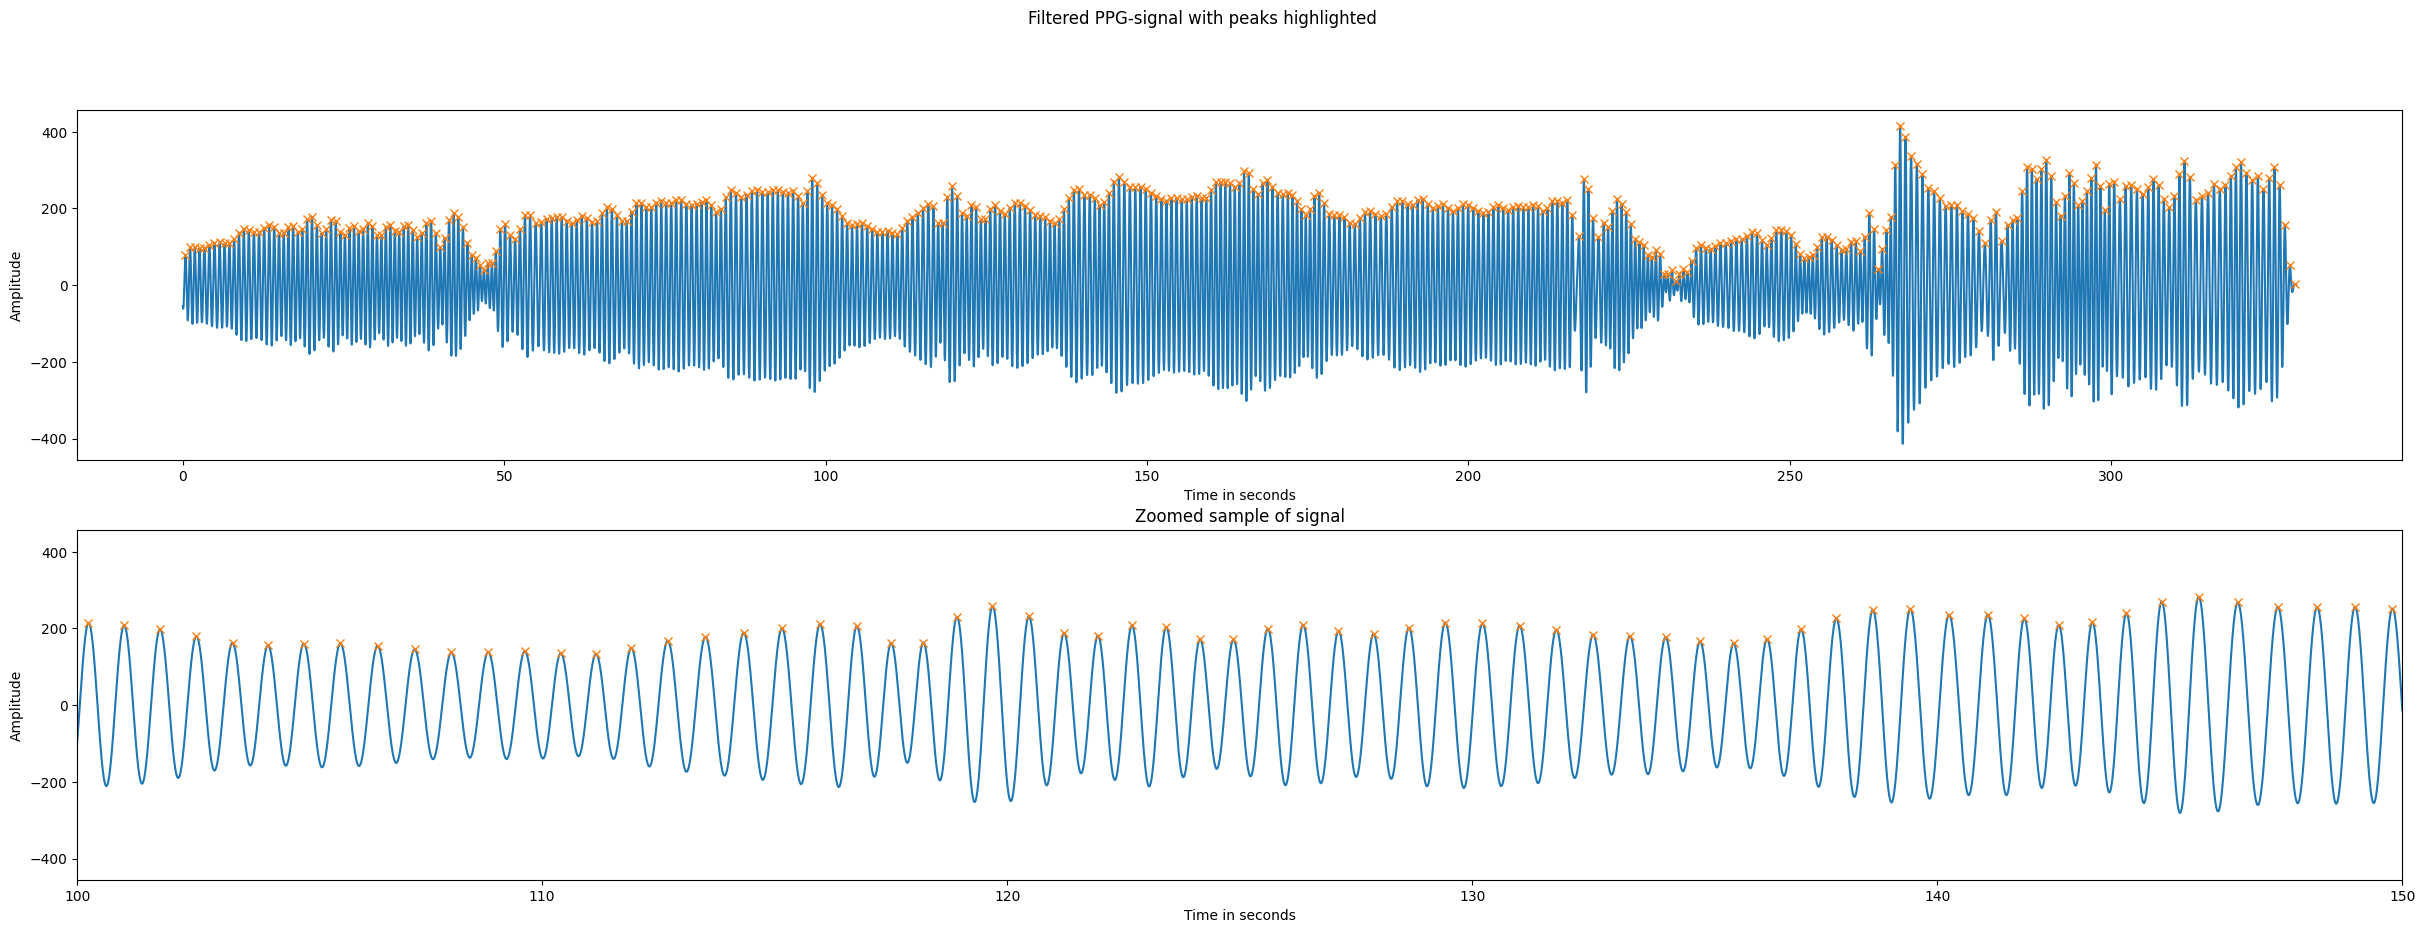

In [107]:
#code
from scipy.signal import argrelextrema

RR_intervals, = scipy.signal.argrelextrema(filt_signal, np.greater)
fig, ax = plt.subplots(2,1, figsize=(30,10))
for j in [0,1]:
    ax[j].plot(time, filt_signal)
    ax[j].set_xlabel("Time in seconds")
    ax[j].set_ylabel("Amplitude")
    ax[j].plot(RR_intervals/Fs, filt_signal[RR_intervals], "x")

    time_btwn_peaks = [np.abs(time[RR_intervals[i]]-time[RR_intervals[i+1]]) for i in range(len(RR_intervals)-1)]
    avg_peak_interval =  np.mean(time_btwn_peaks)
    heart_rate = 60.0 / avg_peak_interval
    
ax[1].set_xlim(100,150)
ax[1].set_title("Zoomed sample of signal")
fig.suptitle("Filtered PPG-signal with peaks highlighted")
print(f"Average heart rate: {heart_rate} BPM")




## Observations: 
The above method is effective in extracting the heart rate, that is 78.4 BPM.

# 6- Calculate SDNN and RMSSD
* AVNN is average of the time interval between successive normal heart beats. 
* SDNN is standard deviation of the time interval between successive normal heart beats (i.e. the RR-intervals).
* RMSSD is the Root mean square of successive RR interval differences.

* Calculate AVNN, SDNN and RMSSD from the “RR_intervals” variable. 
* These are heart rate variability parameters. Report the AVNN, SDNN and RMSSD values. 
* RMSSD formula can be found in https://www.biopac.com/application/ecg-cardiology/advanced-feature/rmssd-for-hrv-analysis/

* Note: Time unit for intervals should be in millisecond.
   
   HINT:
        Use np.diff(RR_intervals) to calculate the difference between successive rr intervals
        Use np.std() for SDNN

$RMSSD=\sqrt{\sum\nolimits_{i=1}^{n-1}\frac{ SD(i)^2}{n-1}}$
        

In [241]:
#code
# interval  
ms = 1e3

AVNN = np.mean(np.diff(time[RR_intervals]))*ms
SDNN = np.std(np.diff(time[RR_intervals]))*ms
RMSSD = np.sqrt( 
    np.sum( 
        np.diff(time[RR_intervals])**2 / (len(RR_intervals)-1) 
        ))*ms
print(f'AVNN: {AVNN:.5}ms\nSDNN: {SDNN:.5}ms\nRMSSD: {RMSSD:.5}ms')


AVNN: 764.85ms
SDNN: 64.59ms
RMSSD: 767.57ms


## Observations:
AVNN, SDNN and RMSSD are shown above. 